In [73]:
import os
import numpy as np
import tensorflow as tf
import random

from sklearn.metrics import precision_score, recall_score, f1_score
from utils.data_loader import get_eval_data
from utils.openmax import get_activations, compute_openmax
from utils.openmax_utils import get_openmax_predict, convert_label, compute_roc, plot_roc, compute_pr, plot_pr

In [74]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [75]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [76]:
SEED = 0
IMG_DIM = 28

In [77]:
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [78]:
model = tf.keras.models.load_model('models/mnist.h5')

In [79]:
(x_eval, y_eval) = get_eval_data()

In [80]:
print(f'x_eval shape: {x_eval.shape}')
print(f'y_eval shape: {y_eval.shape}')

x_eval shape: (20000, 28, 28, 1)
y_eval shape: (20000,)


In [81]:
logits_eval, softmax_eval = get_activations(
    x_eval.reshape(-1, IMG_DIM, IMG_DIM, 1), model)

625/625 [==============================] - 0s 648us/step


In [82]:
openmax = []
prob_u = []
for logits in logits_eval:
    temp_openmax, temp_prob_u = compute_openmax(logits.reshape(1, -1))
    openmax.append(temp_openmax)
    prob_u.append(temp_prob_u)

openmax = np.array(openmax)
prob_u = np.array(prob_u)

In [83]:
y_hat = []
for probs in openmax:
    temp = get_openmax_predict(probs, threshold=0.0004)
    y_hat.append(temp)

y_hat = np.array(y_hat)

In [84]:
# y_hat = np.argmax(openmax, axis=1)

In [85]:
y_hat = convert_label(y_hat)
y_eval = convert_label(y_eval)

In [86]:
precision_score(y_eval, y_hat)

0.9595230938783689

In [87]:
recall_score(y_eval, y_hat)

0.9577

In [88]:
f1_score(y_eval, y_hat)

0.9586106801461388

In [89]:
roc = compute_roc(y_eval, prob_u)

In [90]:
pr = compute_pr(y_eval, prob_u)

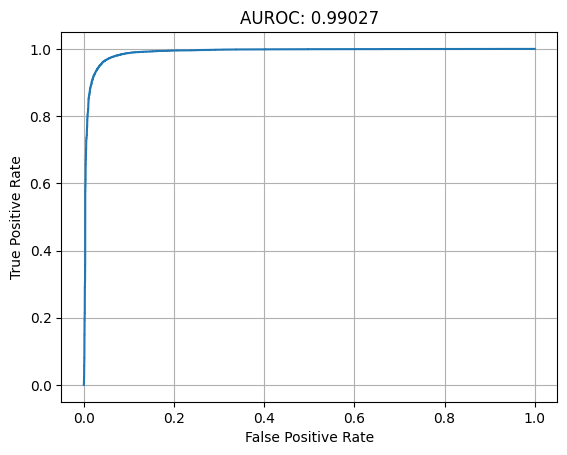

In [91]:
plot_roc(roc)

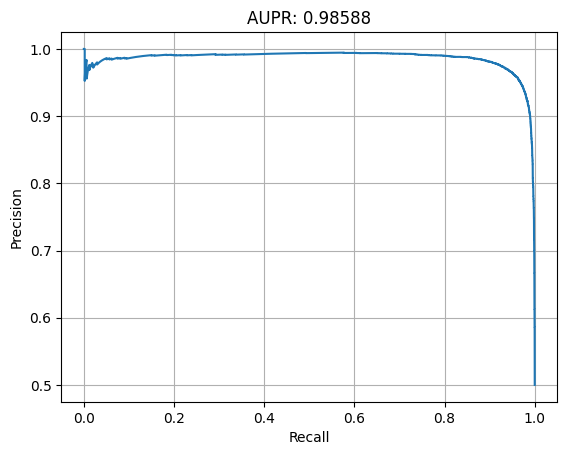

In [92]:
plot_pr(pr)

In [93]:
print(roc['thresholds'])

[           inf 9.86394411e-01 9.28507263e-01 ... 5.48091064e-09
 5.46877645e-09 1.80403705e-13]


In [94]:
print(pr['thresholds'])

[1.80403705e-13 4.97121965e-13 5.53197470e-13 ... 9.77182565e-01
 9.83521003e-01 9.86394411e-01]


In [95]:
np.savetxt('roc_thresholds.csv', roc['thresholds'], delimiter=',')

In [96]:
np.savetxt('pr_thresholds.csv', pr['thresholds'], delimiter=',')